# Quant intuitions

Alpha Pick's stock picking is based on five dimensions:
- Price momentum
- Value
- Growth
- Profitability
- EPS revisions

This notebook simulate their criterion and show even a very crude simulation of the first four – EPS revisions history is unavailable – can significantly beat SPX. I think it's not random.

The next step is to improve the features on the first four dimentions and see if the model can perform better.

In [150]:
from datetime import datetime
from functools import cache
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import logging

from utils.logging_config import setup_logging
from fmp_data import Dataset, AFTER_PRICE, FMPPriceLoader

import pandas as pd

def get_quarter(date):
    dt = pd.to_datetime(date)
    quarter = (dt.month - 1) // 3 + 1
    return f'{dt.year}Q{quarter}'

@cache
def get_price(symbol, date):
    pl = FMPPriceLoader()
    return pl.get_last_available_price(symbol, date)


In [151]:

setup_logging(logging.CRITICAL)

stocks = fmp('SELECT * from stock22to24')
symbols = stocks.symbol.unique()
pl = FMPPriceLoader()

d = Dataset(symbols,{
    AFTER_PRICE: '',
    'revenue': '',
    'free_cash_flow_per_share': 'fcf_per_share',
    'operating_profit_margin': 'opm',
    }).data

d = d.merge(stocks, on='symbol', how='inner')
d['quarter'] = d.date.apply(get_quarter) 

In [344]:
t = d
spx = {}
pl = FMPPriceLoader()
price_rec = []
for date, symbol in t[['date', 'symbol']].values:
    one_quarter_later = pd.to_datetime(date) + pd.Timedelta(days=28 * 3)
    if one_quarter_later <= pd.to_datetime('2024-11-01'):
        try:
            price, _ = pl.get_last_available_price(symbol, one_quarter_later)
        except KeyError:
            print('Failed to get price for {} on {}'.format(symbol, one_quarter_later))
        else:
            try:
                spx_date, _  = get_price('^SPX', date)
                spx_1q_later, _ = get_price('^SPX', one_quarter_later)
            except KeyError:
                print('Failed to get price for ^SPX on {}'.format(one_quarter_later))
            else:
                price_rec.append({'date': date,'symbol': symbol, 'one_quarter_later': price, 'spx': spx_date, 'spx_1q_later': spx_1q_later})
prices = pd.DataFrame.from_records(price_rec)
data = t.merge(prices, how='left', on=['date', 'symbol'])
data = data[~data.one_quarter_later.isnull()].copy()
data['fcf_to_price'] = data['fcf_per_share'] / data['after_price']
data['d90'] = data.groupby('symbol')['after_price'].pct_change()
data['d180'] = data.groupby('symbol')['after_price'].pct_change(periods=2)
data['d270'] = data.groupby('symbol')['after_price'].pct_change(periods=3)
data['d360'] = data.groupby('symbol')['after_price'].pct_change(periods=4)
data['revenue_yoy'] = data.groupby('symbol')['revenue'].pct_change(periods=4)
data['price1q'] = data['one_quarter_later'] / data['after_price'] - 1
data['spx1q'] = data['spx_1q_later'] / data['spx'] - 1
data['by_spx'] = data['price1q'] - data['spx1q']
data = data.dropna()     

gp = data.groupby(['quarter', 'sector'])

rank_cols = ['fcf_to_price', 'opm', 'd90', 'd180', 'd270', 'd360', 'revenue_yoy']
ranks_df = pd.DataFrame()
for col in rank_cols:
    # Rank the column within each sector
    ranks = gp[col].rank(method='dense', ascending=True) # higher rank means bigger value
    
    # Normalize the ranks to percentiles
    ranks_percentile = ranks / gp[col].transform('count')
    
    # Store the percentile column in the new DataFrame
    ranks_df[f'{col}_q'] = ranks_percentile
    ranks_df[f'{col}_rank'] = ranks
data = pd.concat([data, ranks_df], axis=1)
data = data.dropna()


Failed to get price for A on 1999-04-25 00:00:00
Failed to get price for A on 1999-07-23 00:00:00
Failed to get price for A on 1999-10-23 00:00:00
Failed to get price for AAL on 1995-03-25 00:00:00
Failed to get price for AAL on 1995-06-23 00:00:00
Failed to get price for AAL on 1995-09-22 00:00:00
Failed to get price for AAL on 1995-12-23 00:00:00
Failed to get price for AAL on 1996-03-24 00:00:00
Failed to get price for AAL on 1996-06-23 00:00:00
Failed to get price for AAL on 1996-09-22 00:00:00
Failed to get price for AAL on 1996-12-23 00:00:00
Failed to get price for AAL on 1997-03-25 00:00:00
Failed to get price for AAL on 1997-06-23 00:00:00
Failed to get price for AAL on 1997-09-22 00:00:00
Failed to get price for AAL on 1997-12-23 00:00:00
Failed to get price for AAL on 1998-03-25 00:00:00
Failed to get price for AAL on 1998-06-23 00:00:00
Failed to get price for AAL on 1998-09-22 00:00:00
Failed to get price for AAL on 1998-12-23 00:00:00
Failed to get price for AAL on 1999-0

/var/folders/jv/zpk9r3mn7dq5ghtk8zl52vt00000gn/T/ipykernel_30506/2846668014.py:24: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['d90'] = data.groupby('symbol')['after_price'].pct_change()
/var/folders/jv/zpk9r3mn7dq5ghtk8zl52vt00000gn/T/ipykernel_30506/2846668014.py:25: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['d180'] = data.groupby('symbol')['after_price'].pct_change(periods=2)
/var/folders/jv/zpk9r3mn7dq5ghtk8zl52vt00000gn/T/ipykernel_30506/2846668014.py:26: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be re

In [102]:

data[(data.quarter == '2022Q1') & (data.sector == 'Technology')][['symbol', 'quarter', 'opm', 'opm_rank', 'opm_q', 'sector', 'spx', 'spx_1q_later', 'after_price', 'price1q', 'spx1q', 'by_spx']].sort_values(by='opm_rank')

,symbol,quarter,opm,opm_rank,opm_q,sector,spx,spx_1q_later,after_price,price1q,spx1q,by_spx
173123,MSTR,2022Q1,1.427115,1.0,0.002597,Technology,4530.41016,3795.72998,48.630000,-0.612790,-0.162166,-0.450624
186219,NVEC,2022Q1,0.699410,2.0,0.005195,Technology,4530.41016,3795.72998,46.480000,-0.113812,-0.162166,0.048354
273193,VRSN,2022Q1,0.648025,3.0,0.007792,Technology,4530.41016,3795.72998,222.460007,-0.263283,-0.162166,-0.101117
261418,TXN,2022Q1,0.522528,4.0,0.010390,Technology,4530.41016,3795.72998,169.330000,-0.170673,-0.162166,-0.008506
79691,DQ,2022Q1,0.521133,5.0,0.012987,Technology,4530.41016,3795.72998,41.320000,0.603824,-0.162166,0.765990
...,...,...,...,...,...,...,...,...,...,...,...,...
20844,ASTS,2022Q1,-11.215539,378.0,0.981818,Technology,4530.41016,3795.72998,9.980000,-0.319639,-0.162166,-0.157473
182185,NN,2022Q1,-13.384487,379.0,0.984416,Technology,4530.41016,3795.72998,7.490000,-0.707610,-0.162166,-0.545444
182206,NNAVW,2022Q1,-13.384487,379.0,0.984416,Technology,4530.41016,3795.72998,1.900000,-0.789474,-0.162166,-0.627307
5675,AEVA,2022Q1,-29.967458,380.0,0.987013,Technology,4530.41016,3795.72998,21.650000,-0.207852,-0.162166,-0.045686


## Looking seprately, none of the dimensions has a strong correlation with price performance.

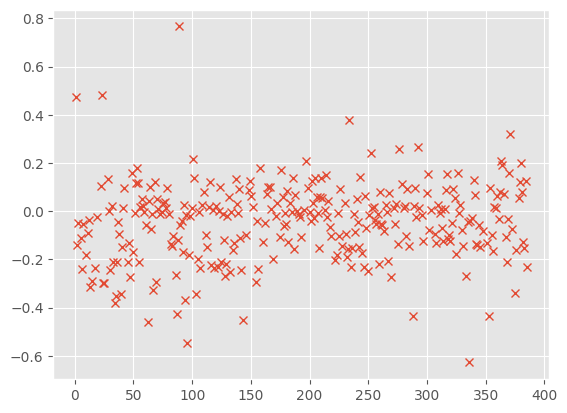

In [378]:

t = data[(data.price1q < 1) & (data.quarter == '2022Q1') & (data.sector == 'Technology')]

if len(t) >= 300:
    t = t.sample(300)
x = t.d180_rank
y = t.by_spx

plt.plot(x, y, 'x')

## The crude model significantly outperforms SPX

In [358]:
data.groupby('quarter')['by_spx'].mean()

quarter
1995Q2    0.042594
1995Q3    0.018934
1995Q4   -0.000876
1996Q1    0.034122
1996Q2   -0.021985
            ...   
2023Q3    0.032583
2023Q4   -0.052575
2024Q1   -0.066488
2024Q2    0.050604
2024Q3   -0.037297
Name: by_spx, Length: 118, dtype: float64

In [391]:
# criterion = (data.d360_q >= 0.9) & 
#     (data.fcf_to_price_q >= 0.9) &
#     (data.opm_q >= 0.9) &
#     (data.revenue_yoy_q >= 0.9) &
#     (data.opm > 0.1) &
#     (data.fcf_to_price > 0.1)

criterion = (data.d360_q >= 0.5) & \
    (data.fcf_to_price_q >= 0.5) & \
    (data.opm_q >= 0.5) & \
    (data.revenue_yoy_q >= 0.5) & \
    (data.opm_q + data.fcf_to_price_q + data.d360_q + data.revenue_yoy_q >= 3.2) & \
    (data.opm > 0.1) & \
    (data.fcf_to_price > 0.1) \

t = data[
    criterion
]


cmp = pd.merge(t.groupby('quarter')['by_spx'].mean(), data.groupby('quarter')['by_spx'].mean(), how='left', left_index=True, right_index=True, suffixes=['_quant', '_all'])
cmp['win'] = cmp['by_spx_quant'] - cmp['by_spx_all']
cmp.sort_index()

,by_spx_quant,by_spx_all,win
quarter,,,
1995Q4,0.053115,-0.000876,0.053991
1996Q1,0.160142,0.034122,0.126020
1996Q2,0.091440,-0.021985,0.113425
1996Q3,-0.011088,-0.029750,0.018662
1996Q4,0.049850,-0.030763,0.080613
...,...,...,...
2023Q2,0.079219,-0.004581,0.083799
2023Q3,0.175284,0.032583,0.142701
2023Q4,0.018941,-0.052575,0.071515


In [388]:
cmp.sum()

by_spx_quant    6.742019
by_spx_all      1.918443
win             4.823576
dtype: float64

In [398]:
for q in cmp.index:
    print(q, cmp.loc[q]['win'])

1995Q4 0.053990796237345554
1996Q1 0.1260195205509109
1996Q2 0.11342500937123054
1996Q3 0.018662021386204514
1996Q4 0.08061272956778644
1997Q1 -0.04763971335996121
1997Q2 -0.2938226684028805
1997Q3 0.09053567769219716
1997Q4 -0.0572243526781696
1998Q1 0.44360810111813564
1998Q2 -0.15184847982746313
1998Q3 0.02923590740570845
1998Q4 0.013710689097263452
1999Q1 -0.08951868197274976
1999Q2 -0.1597371766544086
1999Q3 -0.0016867948370699742
1999Q4 -0.12949962118522013
2000Q1 0.3813807949220661
2000Q2 0.14938279611956312
2000Q3 0.07760525559374933
2000Q4 -0.013958450368879605
2001Q1 -0.05267178028818547
2001Q2 0.05444969114767592
2001Q3 0.02536007386237847
2001Q4 0.06405405325073782
2002Q1 0.23268948599140193
2002Q2 0.040874252696560205
2002Q3 -0.04234604970291423
2002Q4 0.023675157052671772
2003Q1 -0.023809077701433715
2003Q2 -0.06845044331113234
2003Q3 0.046866134141698546
2003Q4 0.11036189593215115
2004Q1 0.07930958943025154
2004Q2 0.2692494145603537
2004Q3 0.042473122572827225
2004Q4 0.1

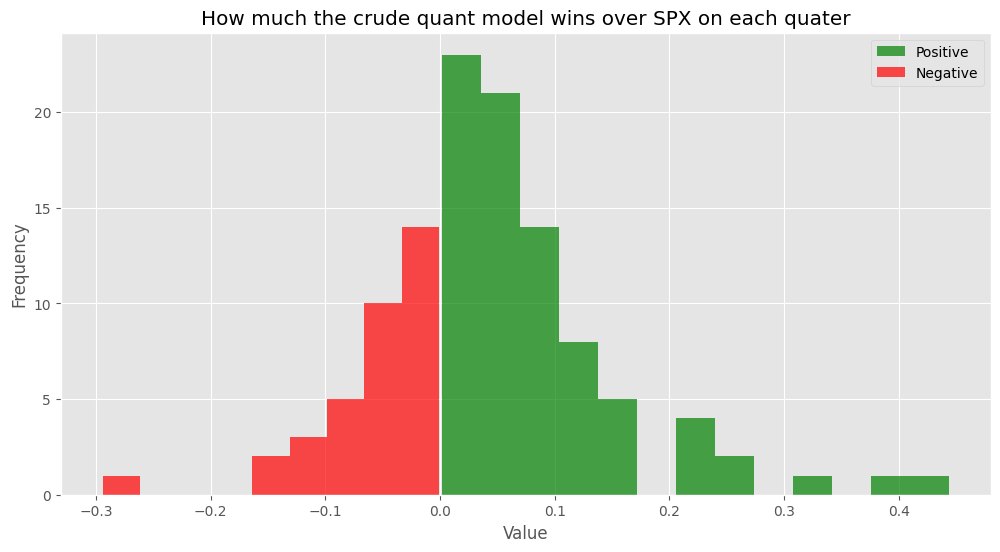

In [408]:
import matplotlib.pyplot as plt
import numpy as np

def histogram(data):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    
    # Separate positive and negative values
    positive = [x for x in data if x >= 0]
    negative = [x for x in data if x < 0]
    
    # Draw histogram for positive values in green
    ax.hist(positive, bins='auto', color='green', alpha=0.7, label='Positive')
    
    # Draw histogram for negative values in red
    ax.hist(negative, bins='auto', color='red', alpha=0.7, label='Negative')
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title('How much the crude quant model wins over SPX on each quater')
    ax.legend()
    
    plt.show()

histogram(cmp.win)

## There's no correlation between SPX and how much the model outperforms, showing the model doesn't depend on market uptrend

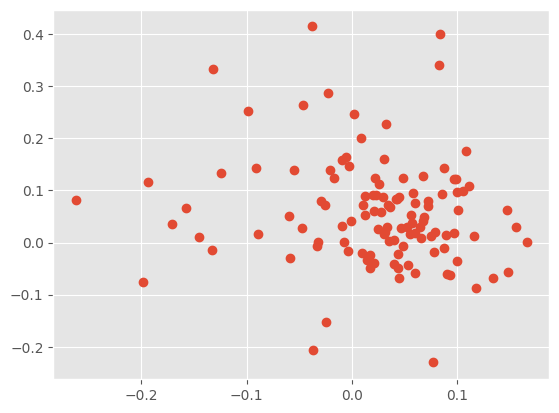

In [396]:
tmp = t.groupby('quarter')[['spx1q', 'by_spx']].mean()
plt.plot(tmp.spx1q, tmp.by_spx, 'o')

In [342]:
data[(data.quarter == '1999Q2') & (data.sector == 'Healthcare')][['symbol', 'opm', 'opm_q', 'opm_rank', 'fcf_to_price', 'fcf_to_price_rank', 'fcf_to_price_q', 'd360', 'd360_rank', 'd360_q']].sort_values(by='d360')

,symbol,opm,opm_q,opm_rank,fcf_to_price,fcf_to_price_rank,fcf_to_price_q,d360,d360_rank,d360_q
180246,NHC,0.047354,0.564356,57.0,0.065451,4.0,0.039604,-0.745902,101.0,1.000000
231225,SIGA,-9.000000,0.930693,94.0,-0.144555,95.0,0.940594,-0.709345,100.0,0.990099
124561,HOLX,-0.155000,0.712871,72.0,-0.066695,90.0,0.891089,-0.674658,99.0,0.980198
269032,VCEL,-8.361538,0.920792,93.0,-0.127717,93.0,0.920792,-0.666667,98.0,0.970297
254244,TMO,0.121817,0.366337,37.0,-0.172382,97.0,0.960396,-0.660485,97.0,0.960396
...,...,...,...,...,...,...,...,...,...,...
217022,RGEN,-0.571429,0.792079,80.0,-0.007422,57.0,0.564356,0.877551,5.0,0.049505
45439,CAMP,0.038168,0.584158,59.0,-0.004472,51.0,0.504950,0.891897,4.0,0.039604
26577,AZTA,-0.003788,0.653465,66.0,-0.011112,60.0,0.594059,1.081731,3.0,0.029703
37014,BLFS,-0.222222,0.742574,75.0,-0.003463,48.0,0.475248,1.750000,2.0,0.019802


In [338]:
data.sector.unique()

array(['Healthcare', 'Basic Materials', 'Industrials', 'Technology',
       'Consumer Cyclical', 'Real Estate', 'Financial Services',
       'Consumer Defensive', 'Communication Services', 'Utilities',
       'Energy'], dtype=object)

# R2 analysis on corelation (unfiltered) showed there's no linear correlation between the four dimensions and the price performance

In [98]:
d = data.replace([np.inf, -np.inf], np.nan).dropna()
d = d[data.sector == 'Technology']
X = d[['fcf_to_price_q', 'opm_q', 'd90_q', 'd180_q', 'd270_q', 'd360_q', 'revenue_yoy_q']]
y = d['price1q']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

R-squared: 0.004734494096949593
Mean Squared Error: 0.08735018143062287
Mean Absolute Error: 0.18756255153429216


In [101]:
data.head()

,symbol,quarter,fcf_to_price_q,opm_q,d90_q,d180_q,d270_q,d360_q,revenue_yoy_q,price1q
7,A,2000-10,0.453929,0.289265,0.271482,0.925803,0.806516,0.482013,0.200065,0.354919
8,A,2001-01,0.772668,0.369389,0.215886,0.172267,0.873068,0.709222,0.259177,-0.288275
9,A,2001-04,0.688251,0.583885,0.871106,0.725779,0.593533,0.912844,0.755744,-0.289720
10,A,2001-07,0.448451,0.647944,0.859905,0.915747,0.852506,0.785504,0.869839,-0.166280
11,A,2001-10,0.011814,0.691849,0.826098,0.900008,0.928297,0.887581,0.895430,0.257440


## Not finished: SMA open mouthed stocks, etc

Many can be done to refine the model, for example, adding "Open Mouth in SMAs" as a feature like below. This effort should be left to other notebooks.

In [397]:
from feature_gen.sma import SMA

t = data[(data.quarter == '2023Q1') & 
    (data.d360_q >= 0.8) & 
    (data.fcf_to_price_q >= 0.8) &
    (data.opm_q >= 0.8) &
    (data.opm_q >= 0.8) &
    (data.revenue_yoy_q >= 0.8)
    ]
symbols = t.symbol.unique()



In [353]:
data[data.quarter == '2023Q1'][['symbol', 'date', 'by_spx', 'price1q', 'spx1q']].describe()

,by_spx,price1q,spx1q
count,3210.000000,3210.000000,3210.000000
mean,-0.043058,0.012007,0.055065
std,0.192799,0.193505,0.013767
min,-0.762165,-0.704000,-0.001219
25%,-0.138944,-0.084272,0.058165
50%,-0.063544,-0.009135,0.058165
75%,0.025890,0.081692,0.058165
max,1.766510,1.824675,0.110451


In [354]:
t[['symbol', 'date', 'by_spx', 'price1q', 'spx1q']].describe()

,by_spx,price1q,spx1q
count,11.000000,11.000000,11.000000
mean,-0.125756,-0.067796,0.057960
std,0.104337,0.104484,0.000682
min,-0.274272,-0.216106,0.055904
25%,-0.170308,-0.113273,0.058165
50%,-0.117349,-0.059184,0.058165
75%,-0.095842,-0.037676,0.058165
max,0.099005,0.157171,0.058165


In [312]:
sma = SMA(symbols, '2022-01-01', '2023-03-31')
sma.values([20, 60, 120])

ms = []
for sym in symbols:
    if sma.has_open_mouth_trend(sym, '2023-03-31', 90, [20, 60, 120], 0.01):
       ms.append(sym) 

In [313]:
t[t.symbol.isin(ms)][['symbol', 'date', 'by_spx', 'price1q', 'spx1q']].describe()

,by_spx,price1q,spx1q
count,1.000000,1.000000,1.000000
mean,-0.148477,-0.090312,0.058165
std,NaN,NaN,NaN
min,-0.148477,-0.090312,0.058165
25%,-0.148477,-0.090312,0.058165
50%,-0.148477,-0.090312,0.058165
75%,-0.148477,-0.090312,0.058165
max,-0.148477,-0.090312,0.058165


In [302]:
t[t.symbol.isin(ms)][['symbol', 'date', 'by_spx', 'price1q', 'spx1q']]

,symbol,date,by_spx,price1q,spx1q
56347,CLAR,2024-03-31,-0.073942,-0.033923,0.040018
235448,SMR,2024-03-31,0.872195,0.912214,0.040018
284139,WWW,2024-03-30,0.245428,0.285446,0.040018
